In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser

In [4]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/SellerNameModel'

In [5]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/SellerNameModel/Dataset/')

In [7]:
df = pd.read_csv("dataset.csv")

In [8]:
df.shape

(64, 31)

In [9]:
df.describe()

,Unnamed: 0,conf,x,y,PageWidth,PageHeight,seller,buyer,receiver,bill,...,client,owner,invoice,for,billing,store,information,receipt,recipient,output
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000,64.000000,64.0,64.000000,64.000000,...,64.000000,64.0,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.0,64.000000
mean,31.500000,87.529906,667.265344,1003.003344,1684.187500,2293.31250,0.004950,0.0,0.005361,0.016716,...,0.005842,0.0,0.112665,0.076581,0.000740,0.0,0.005364,0.003099,0.0,0.421875
std,18.618987,15.227195,368.341824,698.961683,119.949708,127.08226,0.039601,0.0,0.030087,0.089608,...,0.027629,0.0,0.141965,0.129818,0.004153,0.0,0.030100,0.017391,0.0,0.497763
min,0.000000,20.509868,170.250000,45.625000,1653.000000,1654.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
25%,15.750000,86.107385,370.375000,342.559152,1653.000000,2337.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
50%,31.500000,92.740324,593.910714,910.125000,1654.000000,2339.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.086557,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
75%,47.250000,95.160755,920.940341,1619.062500,1654.000000,2339.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.171338,0.101998,0.000000,0.0,0.000000,0.000000,0.0,1.000000
max,63.000000,96.875511,1442.250000,2164.000000,2339.000000,2339.00000,0.316808,0.0,0.171564,0.511185,...,0.174164,0.0,0.584646,0.518143,0.023683,0.0,0.171640,0.099171,0.0,1.000000


In [10]:
len(df["imageName"].unique())

18

In [13]:
def preProcess(df):
    df["isLeft"] = 0
    df["isRight"] = 0
    df["isBottom"] = 0
    df["isTop"] = 0
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y<Y:
            df["isBottom"][index]=1
        elif y>Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    
    colsToDrop = ["Unnamed: 0", "imageName", "text", "PageHeight", "PageWidth", "conf"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [14]:
preProcess(df)

/tmp/ipykernel_37706/1189984919.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_37706/1189984919.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_37706/1189984919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_37706/1189984919.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [15]:
df

,x,y,seller,buyer,receiver,bill,to,from,by,ship,...,billing,store,information,receipt,recipient,output,isLeft,isRight,isBottom,isTop
0,0.582830,0.916204,0.316808,0,0.0,0.0,0.150471,0.0,0.000000,0,...,0.0,0,0.00000,0.0,0,1,0,1,0,1
1,0.103235,0.890227,0.000000,0,0.0,0.0,0.000000,0.0,0.000000,0,...,0.0,0,0.00000,0.0,0,0,1,0,0,1
2,0.297598,0.713523,0.000000,0,0.0,0.0,0.155007,0.0,0.000000,0,...,0.0,0,0.17164,0.0,0,1,1,0,0,1
3,0.655196,0.725833,0.000000,0,0.0,0.0,0.508049,0.0,0.165947,0,...,0.0,0,0.00000,0.0,0,0,0,1,0,1
4,0.351765,0.361818,0.000000,0,0.0,0.0,0.000000,0.0,0.000000,0,...,0.0,0,0.17164,0.0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.803690,0.720714,0.000000,0,0.0,0.0,0.279385,0.0,0.157426,0,...,0.0,0,0.00000,0.0,0,1,0,1,0,1
60,0.158701,0.155266,0.000000,0,0.0,0.0,0.000000,0.0,0.000000,0,...,0.0,0,0.00000,0.0,0,1,1,0,1,0
61,0.459165,0.233647,0.000000,0,0.0,0.0,0.000000,0.0,0.000000,0,...,0.0,0,0.00000,0.0,0,0,1,0,1,0
62,0.284029,0.727688,0.000000,0,0.0,0.0,0.069640,0.0,0.000000,0,...,0.0,0,0.00000,0.0,0,0,1,0,0,1


In [16]:
df.describe()

,x,y,seller,buyer,receiver,bill,to,from,by,ship,...,billing,store,information,receipt,recipient,output,isLeft,isRight,isBottom,isTop
count,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,...,64.000000,64.0,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.398964,0.439109,0.004950,0.0,0.005361,0.016716,0.069037,0.011465,0.048848,0.0,...,0.000740,0.0,0.005364,0.003099,0.0,0.421875,0.656250,0.343750,0.546875,0.453125
std,0.223423,0.304765,0.039601,0.0,0.030087,0.089608,0.143732,0.039810,0.110023,0.0,...,0.004153,0.0,0.030100,0.017391,0.0,0.497763,0.478714,0.478714,0.501733,0.501733
min,0.102932,0.020739,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.213633,0.146469,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.355523,0.401703,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.557133,0.720714,0.000000,0.0,0.000000,0.000000,0.041538,0.000000,0.024547,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
max,0.848382,0.932045,0.316808,0.0,0.171564,0.511185,0.702004,0.196020,0.484227,0.0,...,0.023683,0.0,0.171640,0.099171,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df.corr()

,x,y,seller,buyer,receiver,bill,to,from,by,ship,...,billing,store,information,receipt,recipient,output,isLeft,isRight,isBottom,isTop
x,1.000000,-0.038806,0.104502,NaN,0.030454,-0.138492,0.327585,0.063321,0.012105,NaN,...,-0.118596,NaN,-0.060186,0.126162,NaN,0.222162,-0.860268,0.860268,0.026232,-0.026232
y,-0.038806,1.000000,0.198788,NaN,-0.031250,-0.145715,0.351563,0.344889,0.161683,NaN,...,-0.145231,NaN,0.058544,-0.227432,NaN,-0.016587,0.090677,-0.090677,-0.898258,0.898258
seller,0.104502,0.198788,1.000000,NaN,-0.022628,-0.023688,0.071945,-0.036571,-0.056378,NaN,...,-0.022628,NaN,-0.022628,-0.022628,NaN,0.147485,-0.174078,0.174078,-0.138409,0.138409
buyer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
receiver,0.030454,-0.031250,-0.022628,NaN,1.000000,-0.033769,0.178142,-0.052135,-0.039983,NaN,...,-0.032258,NaN,-0.032258,-0.032258,NaN,0.210251,-0.059086,0.059086,0.163487,-0.163487
bill,-0.138492,-0.145715,-0.023688,NaN,-0.033769,1.000000,-0.052144,-0.054576,-0.084134,NaN,...,-0.033769,NaN,-0.033769,-0.033769,NaN,-0.143735,0.118528,-0.118528,0.171143,-0.171143
to,0.327585,0.351563,0.071945,NaN,0.178142,-0.052144,1.000000,-0.072476,0.411215,NaN,...,-0.086950,NaN,0.010663,-0.086950,NaN,0.152225,-0.286608,0.286608,-0.300847,0.300847
from,0.063321,0.344889,-0.036571,NaN,-0.052135,-0.054576,-0.072476,1.000000,-0.068080,NaN,...,-0.052135,NaN,-0.052135,-0.052135,NaN,0.298478,0.003849,-0.003849,-0.318893,0.318893
by,0.012105,0.161683,-0.056378,NaN,-0.039983,-0.084134,0.411215,-0.068080,1.000000,NaN,...,-0.080370,NaN,-0.080370,-0.080370,NaN,-0.066828,-0.045469,0.045469,-0.171805,0.171805
ship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.drop(columns=["buyer", "by", "ship", "customer", "purchaser", "supplier", "client", "owner", "invoice", "for", "store", "information", "recipient", "isBottom", "isTop"], inplace=True)

In [19]:
df

,x,y,seller,receiver,bill,to,from,details,consignee,billing,receipt,output,isLeft,isRight
0,0.582830,0.916204,0.316808,0.0,0.0,0.150471,0.0,0.0,0.0,0.0,0.0,1,0,1
1,0.103235,0.890227,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,1,0
2,0.297598,0.713523,0.000000,0.0,0.0,0.155007,0.0,0.0,0.0,0.0,0.0,1,1,0
3,0.655196,0.725833,0.000000,0.0,0.0,0.508049,0.0,0.0,0.0,0.0,0.0,0,0,1
4,0.351765,0.361818,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.803690,0.720714,0.000000,0.0,0.0,0.279385,0.0,0.0,0.0,0.0,0.0,1,0,1
60,0.158701,0.155266,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0
61,0.459165,0.233647,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,1,0
62,0.284029,0.727688,0.000000,0.0,0.0,0.069640,0.0,0.0,0.0,0.0,0.0,0,1,0


In [20]:
df.corr()

,x,y,seller,receiver,bill,to,from,details,consignee,billing,receipt,output,isLeft,isRight
x,1.000000,-0.038806,0.104502,0.030454,-0.138492,0.327585,0.063321,0.214160,0.140356,-0.118596,0.126162,0.222162,-0.860268,0.860268
y,-0.038806,1.000000,0.198788,-0.031250,-0.145715,0.351563,0.344889,0.081562,-0.226434,-0.145231,-0.227432,-0.016587,0.090677,-0.090677
seller,0.104502,0.198788,1.000000,-0.022628,-0.023688,0.071945,-0.036571,-0.037216,-0.022628,-0.022628,-0.022628,0.147485,-0.174078,0.174078
receiver,0.030454,-0.031250,-0.022628,1.000000,-0.033769,0.178142,-0.052135,-0.053054,-0.032258,-0.032258,-0.032258,0.210251,-0.059086,0.059086
bill,-0.138492,-0.145715,-0.023688,-0.033769,1.000000,-0.052144,-0.054576,-0.042638,0.014132,-0.033769,-0.033769,-0.143735,0.118528,-0.118528
to,0.327585,0.351563,0.071945,0.178142,-0.052144,1.000000,-0.072476,-0.143004,-0.086950,-0.086950,-0.086950,0.152225,-0.286608,0.286608
from,0.063321,0.344889,-0.036571,-0.052135,-0.054576,-0.072476,1.000000,0.518669,-0.052135,-0.052135,-0.052135,0.298478,0.003849,-0.003849
details,0.214160,0.081562,-0.037216,-0.053054,-0.042638,-0.143004,0.518669,1.000000,0.224951,-0.009906,-0.053054,0.135139,-0.195145,0.195145
consignee,0.140356,-0.226434,-0.022628,-0.032258,0.014132,-0.086950,-0.052135,0.224951,1.000000,-0.032258,-0.032258,0.210251,-0.248160,0.248160
billing,-0.118596,-0.145231,-0.022628,-0.032258,-0.033769,-0.086950,-0.052135,-0.009906,-0.032258,1.000000,-0.032258,-0.153426,0.129989,-0.129989


In [21]:
df.shape

(64, 14)

In [22]:
len(df[df["output"]==0])

37

In [23]:
len(df[df["output"]==1])

27

In [24]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [25]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [26]:
xTrain.shape

(51, 13)

In [27]:
xTest.shape

(13, 13)

In [28]:
yTrain.shape

(51,)

In [29]:
yTest.shape

(13,)

In [51]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(13, ), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                448       
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

In [54]:
history = model.fit(xTrain, yTrain,
          epochs=300, batch_size=2)

Epoch 1/300
26/26 [==============================] - 1s 1ms/step - loss: 0.6834 - accuracy: 0.6078 - precision: 0.5417 - recall: 0.5909 - true_positives: 13.0000 - true_negatives: 18.0000 - false_positives: 11.0000 - false_negatives: 9.0000                  
Epoch 2/300
26/26 [==============================] - 0s 1ms/step - loss: 0.6675 - accuracy: 0.6471 - precision: 0.6111 - recall: 0.5000 - true_positives: 11.0000 - true_negatives: 22.0000 - false_positives: 7.0000 - false_negatives: 11.0000     
Epoch 3/300
26/26 [==============================] - 0s 1ms/step - loss: 0.6548 - accuracy: 0.6471 - precision: 0.6111 - recall: 0.5000 - true_positives: 11.0000 - true_negatives: 22.0000 - false_positives: 7.0000 - false_negatives: 11.0000 
Epoch 4/300
26/26 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.6471 - precision: 0.6111 - recall: 0.5000 - true_positives: 11.0000 - true_negatives: 22.0000 - false_positives: 7.0000 - false_negatives: 11.0000             

26/26 [==============================] - 0s 1ms/step - loss: 0.4918 - accuracy: 0.8039 - precision: 0.8000 - recall: 0.7273 - true_positives: 16.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 6.0000          
Epoch 34/300
26/26 [==============================] - 0s 1ms/step - loss: 0.4829 - accuracy: 0.8039 - precision: 0.8000 - recall: 0.7273 - true_positives: 16.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 6.0000      
Epoch 35/300
26/26 [==============================] - 0s 1ms/step - loss: 0.4716 - accuracy: 0.8235 - precision: 0.8095 - recall: 0.7727 - true_positives: 17.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 5.0000  
Epoch 36/300
26/26 [==============================] - 0s 1ms/step - loss: 0.4652 - accuracy: 0.8235 - precision: 0.8421 - recall: 0.7273 - true_positives: 16.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 6.0000              
Epoch 37/300
26/2

26/26 [==============================] - 0s 1ms/step - loss: 0.2920 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000      
Epoch 67/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2923 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000  
Epoch 68/300
26/26 [==============================] - 0s 1ms/step - loss: 0.3062 - accuracy: 0.8235 - precision: 0.8095 - recall: 0.7727 - true_positives: 17.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 5.0000          
Epoch 69/300
26/26 [==============================] - 0s 1ms/step - loss: 0.3089 - accuracy: 0.8627 - precision: 0.8000 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 24.0000 - false_positives: 5.0000 - false_negatives: 2.0000              
Epoch 70/300
26/2

26/26 [==============================] - 0s 1ms/step - loss: 0.2384 - accuracy: 0.8627 - precision: 0.8000 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 24.0000 - false_positives: 5.0000 - false_negatives: 2.0000          
Epoch 100/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.8627 - precision: 0.8000 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 24.0000 - false_positives: 5.0000 - false_negatives: 2.0000  
Epoch 101/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000  
Epoch 102/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2347 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000  
Epoch 103/300
26/26 [=========

26/26 [==============================] - 0s 1ms/step - loss: 0.2102 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000  
Epoch 133/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2201 - accuracy: 0.9020 - precision: 0.8696 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 2.0000              
Epoch 134/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2254 - accuracy: 0.8627 - precision: 0.8000 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 24.0000 - false_positives: 5.0000 - false_negatives: 2.0000  
Epoch 135/300
26/26 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.9020 - precision: 0.9048 - recall: 0.8636 - true_positives: 19.0000 - true_negatives: 27.0000 - false_positives: 2.0000 - false_negatives: 3.0000  
Epoch 136/300
26/26 [=====

26/26 [==============================] - 0s 1ms/step - loss: 0.1944 - accuracy: 0.9020 - precision: 0.8696 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 2.0000  
Epoch 165/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000              
Epoch 166/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1966 - accuracy: 0.9020 - precision: 0.8696 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 2.0000  
Epoch 167/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1981 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000              
Epoch 168/300


26/26 [==============================] - 0s 1ms/step - loss: 0.1878 - accuracy: 0.8824 - precision: 0.8333 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 25.0000 - false_positives: 4.0000 - false_negatives: 2.0000          
Epoch 198/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1858 - accuracy: 0.8627 - precision: 0.8000 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 24.0000 - false_positives: 5.0000 - false_negatives: 2.0000              
Epoch 199/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1843 - accuracy: 0.9216 - precision: 0.9500 - recall: 0.8636 - true_positives: 19.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 3.0000              
Epoch 200/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1813 - accuracy: 0.9216 - precision: 0.9091 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 27.0000 - false_positives: 2.0000 - false_negatives: 2.0000  
Epoch 

26/26 [==============================] - 0s 1ms/step - loss: 0.1680 - accuracy: 0.9412 - precision: 0.9524 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 2.0000              
Epoch 230/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.9020 - precision: 0.8696 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 2.0000      
Epoch 231/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1670 - accuracy: 0.9020 - precision: 0.8696 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 2.0000              
Epoch 232/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1645 - accuracy: 0.9412 - precision: 0.9524 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 2.0000             

26/26 [==============================] - 0s 1ms/step - loss: 0.1643 - accuracy: 0.9608 - precision: 0.9545 - recall: 0.9545 - true_positives: 21.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 1.0000  
Epoch 262/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1795 - accuracy: 0.9216 - precision: 0.9500 - recall: 0.8636 - true_positives: 19.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 3.0000  
Epoch 263/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.9216 - precision: 0.8750 - recall: 0.9545 - true_positives: 21.0000 - true_negatives: 26.0000 - false_positives: 3.0000 - false_negatives: 1.0000  
Epoch 264/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.9412 - precision: 0.9130 - recall: 0.9545 - true_positives: 21.0000 - true_negatives: 27.0000 - false_positives: 2.0000 - false_negatives: 1.0000              
Epoch 265/300
26/26 [=====

26/26 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.9608 - precision: 0.9545 - recall: 0.9545 - true_positives: 21.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 1.0000      
Epoch 294/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1449 - accuracy: 0.9412 - precision: 0.9130 - recall: 0.9545 - true_positives: 21.0000 - true_negatives: 27.0000 - false_positives: 2.0000 - false_negatives: 1.0000              
Epoch 295/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1474 - accuracy: 0.9412 - precision: 0.9524 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 2.0000  
Epoch 296/300
26/26 [==============================] - 0s 1ms/step - loss: 0.1469 - accuracy: 0.9412 - precision: 0.9524 - recall: 0.9091 - true_positives: 20.0000 - true_negatives: 28.0000 - false_positives: 1.0000 - false_negatives: 2.0000  
Epoch 297/300
26/26 [=

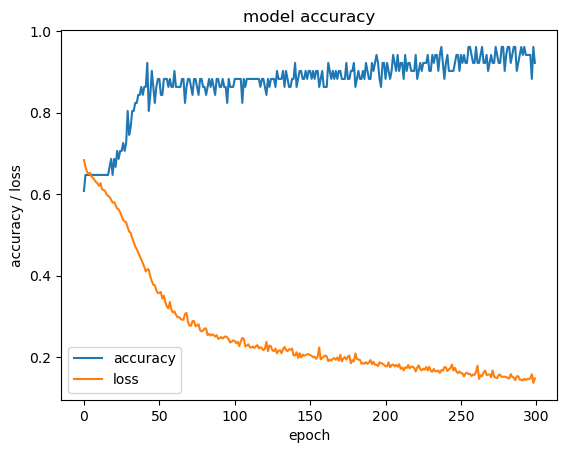

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [57]:
model.evaluate(xTest, yTest)

1/1 [==============================] - 0s 239ms/step - loss: 1.4601 - accuracy: 0.6923 - precision: 0.6000 - recall: 0.6000 - true_positives: 3.0000 - true_negatives: 6.0000 - false_positives: 2.0000 - false_negatives: 2.0000


[1.4600653648376465,
 0.692307710647583,
 0.6000000238418579,
 0.6000000238418579,
 3.0,
 6.0,
 2.0,
 2.0]

In [ ]:
pwd

In [ ]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Models/')

In [ ]:
model.save("SellerName.h5")